In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Alzheimer MRI Classification/archive.zip'


Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

# Import Necessary Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# from sklearn.model_selection import KFold

start = time.time()

# Experiment 1
* Optimizer = SGD with momentum = 0.9
* learning rate = 0.001
* Data Augmentation Techniques = image zooming, brightness change
* batch size = 20 while training
* Architecture = VGG16
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = reLU
* SMOTE = None

# Variables

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 5                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs5


# Import Data From Local Drive

In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",target_size=dim,batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:

# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


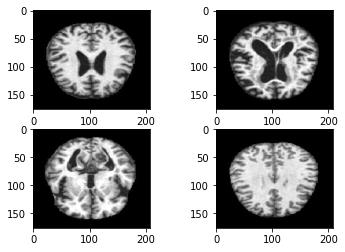

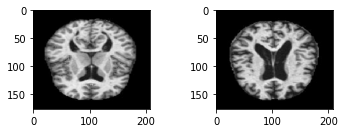

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


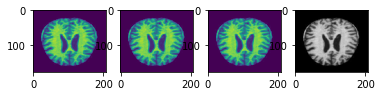

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/5
220/220 [==============================] - 92s 252ms/step - loss: 1.0429 - accuracy: 0.5099 - val_loss: 0.8798 - val_accuracy: 0.5892
Epoch 2/5
220/220 [==============================] - 51s 233ms/step - loss: 0.8362 - accuracy: 0.6212 - val_loss: 0.7704 - val_accuracy: 0.6545
Epoch 3/5
220/220 [==============================] - 52s 238ms/step - loss: 0.7177 - accuracy: 0.6849 - val_loss: 0.6951 - val_accuracy: 0.6975
Epoch 4/5
220/220 [==============================] - 53s 242ms/step - loss: 0.6178 - accuracy: 0.7406 - val_loss: 0.6781 - val_accuracy: 0.7293
Epoch 5/5
138/138 [==============================] - 20s 111ms/step - loss: 0.3906 - accuracy: 0.8403
Accuracy: 84.03%


In [ ]:
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15
scores = vg_model.evaluate(train_data, train_labels)

Epoch 1/5
220/220 [==============================] - 53s 238ms/step - loss: 0.3960 - accuracy: 0.8457 - val_loss: 0.4351 - val_accuracy: 0.8201
Epoch 2/5
220/220 [==============================] - 54s 244ms/step - loss: 0.2892 - accuracy: 0.8924 - val_loss: 0.3269 - val_accuracy: 0.8726
Epoch 3/5
220/220 [==============================] - 54s 246ms/step - loss: 0.2082 - accuracy: 0.9286 - val_loss: 0.2977 - val_accuracy: 0.8997
Epoch 4/5
220/220 [==============================] - 54s 245ms/step - loss: 0.1587 - accuracy: 0.9477 - val_loss: 0.2041 - val_accuracy: 0.9379
Epoch 5/5
138/138 [==============================] - 13s 97ms/step - loss: 0.0517 - accuracy: 0.9882


In [ ]:
print("Accuracy: %.2f%%" %(scores[1]*100))

Accuracy: 98.82%


# Plots and Values

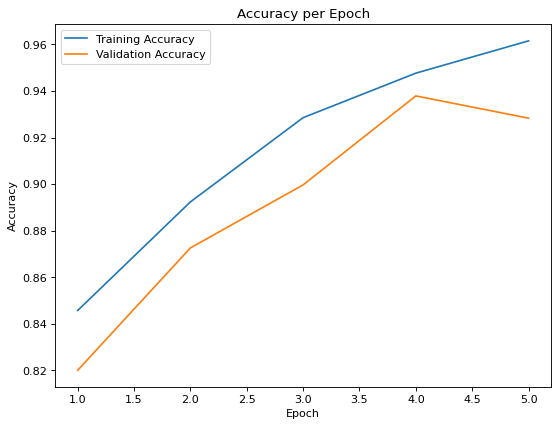

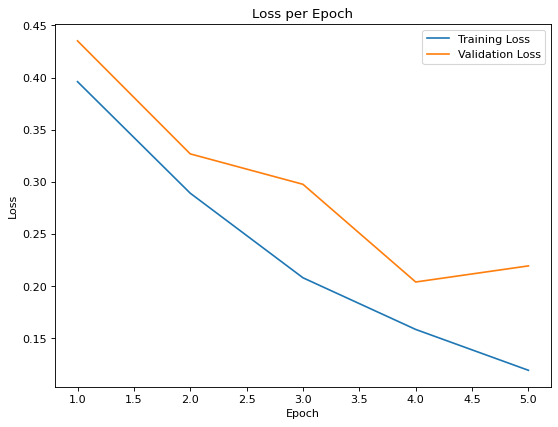

image dimensions:  (176, 208)
validation split percentage:  0.2
zoom:  [0.99, 1.01]
Learning Rate:  0.0001
batch size:  20
epochs:  5
brightness range:  [0.8, 1.2]
Model trained from scratch? :  True
Total Time Elapsed = 15 minutes


In [ ]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# print(np.amax.model_history.history['val_acc'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 4s 88ms/step - loss: 0.2073 - accuracy: 0.9148
Train Accuracy: 98.82%
Validation Accuracy: 92.83%
Test Accuracy: 91.48%


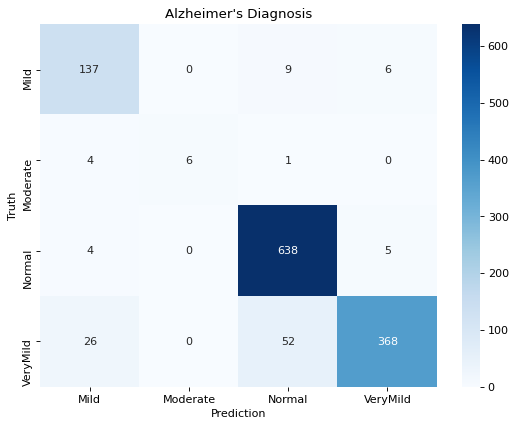

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       152
           1       1.00      0.55      0.71        11
           2       0.91      0.99      0.95       647
           3       0.97      0.83      0.89       446

    accuracy                           0.91      1256
   macro avg       0.92      0.81      0.85      1256
weighted avg       0.92      0.91      0.91      1256



# Saving the Model

In [ ]:
# ## saving in HDF5 format
# save_name = '%s_testacc%2d.h5'%(save_model_name,(test_scores[1]*100))
# vg_model.save('/kaggle/input/%s'%save_name)
# print(save_name)


# ## save the model_history


# Load Model

In [ ]:
## choose the model to load ##
## comment out when not using ##

vg_model = load_model("/kaggle/input/valsplit20-epochs50-testacc98h5/valsplit20_epochs50_testacc98.h5") 


# Experiment 2
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change
* batch size = 20 while training
* Architecture = VGG16
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = reLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


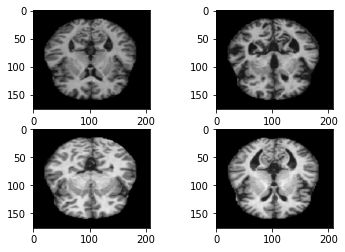

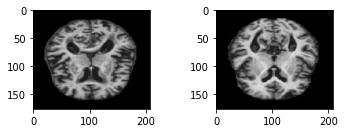

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


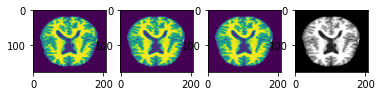

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
220/220 [==============================] - 155s 536ms/step - loss: 1.0830 - accuracy: 0.7527 - precision: 0.5088 - recall: 0.3088 - auc: 0.7773 - val_loss: 1.0369 - val_accuracy: 0.7723 - val_precision: 0.5562 - val_recall: 0.4411 - val_auc: 0.8078
Epoch 2/10
220/220 [==============================] - 110s 500ms/step - loss: 0.9639 - accuracy: 0.7931 - precision: 0.6407 - recall: 0.3927 - auc: 0.8269 - val_loss: 0.9521 - val_accuracy: 0.7914 - val_precision: 0.8377 - val_recall: 0.2054 - val_auc: 0.8350
Epoch 3/10
220/220 [==============================] - 110s 501ms/step - loss: 0.8883 - accuracy: 0.8096 - precision: 0.6760 - recall: 0.4576 - auc: 0.8553 - val_loss: 0.8425 - val_accuracy: 0.8133 - val_precision: 0.6992 - val_recall: 0.4443 - val_auc: 0.8643
Epoch 4/10
220/220 [==============================] - 110s 501ms/step - loss: 0.8220 - accuracy: 0.8259 - precision: 0.7038 - recall: 0.5245 - auc: 0.8787 - val_loss: 0.8898 - val_accuracy: 0.7954 - val_precision: 0.5976

# Plots and Values

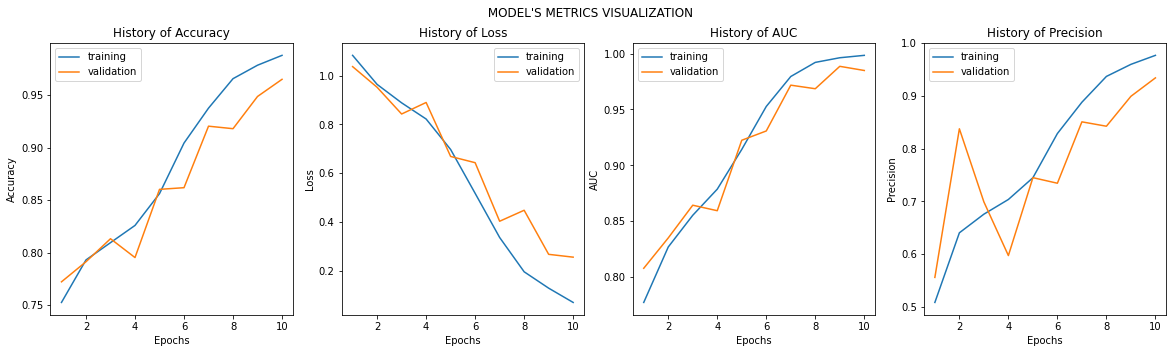

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 7s 187ms/step - loss: 0.2299 - accuracy: 0.9670 - precision: 0.9381 - recall: 0.9291 - auc: 0.9883
Train Accuracy: 99.57%
Validation Accuracy: 96.50%
Test Accuracy: 96.70%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.97
Precision =  0.94
Recall =  0.93
AUC =  0.99


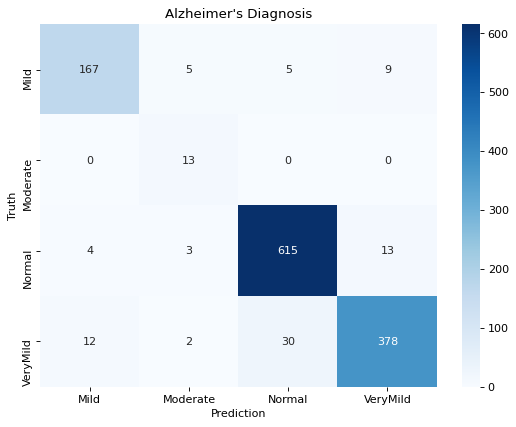

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       186
           1       0.57      1.00      0.72        13
           2       0.95      0.97      0.96       635
           3       0.94      0.90      0.92       422

    accuracy                           0.93      1256
   macro avg       0.84      0.94      0.88      1256
weighted avg       0.94      0.93      0.93      1256



# Saving the Model

In [ ]:
vg_model.save('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/my_model.h5')

In [ ]:
model=load_model('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/my_model.h5')

In [ ]:
train_pred = model.predict(train_data)
train_pred = np.argmax(train_pred, axis=1)
train_labels = np.argmax(train_labels, axis=1)
print("Train Cohen Kappa Score",np.round(cohen_kappa_score(train_labels, train_pred),2))

test_pred = model.predict(test_data)
test_pred = np.argmax(test_pred, axis=1)
test_labels = np.argmax(test_labels, axis=1)
print("Test Cohen kappa Score",np.round(cohen_kappa_score(test_labels, test_pred),2))

Train Cohen Kappa Score 0.94
Test Cohen kappa Score 0.97


# GradCam

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem999.jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = vg_model.predict(image) 
i = np.argmax(preds[0])
print(i)

3


In [ ]:
for idx in range(len(vg_model.layers)):
  print(vg_model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d
flatten
dense
dropout
dense_1


In [ ]:
icam = GradCAM(vg_model, i) 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem999.jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


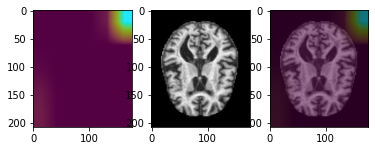

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = vg_model.predict(image) 
i = np.argmax(preds[0])
print(i)

0


In [ ]:
for idx in range(len(vg_model.layers)):
  print(vg_model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d
flatten
dense
dropout
dense_1


In [ ]:
icam = GradCAM(vg_model, i,'block5_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


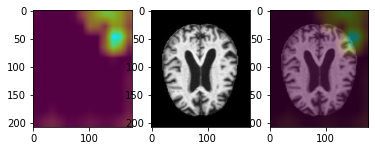

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

# Experiment 3
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change
* batch size = 20 while training
* Architecture = VGG16
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = leaky-ReLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


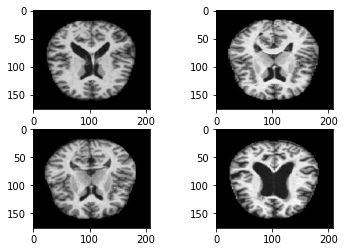

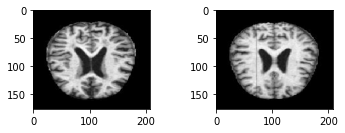

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


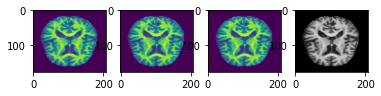

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation = LeakyReLU(alpha = 0.3),kernel_initializer='he_uniform') (flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
220/220 [==============================] - 156s 540ms/step - loss: 1.0987 - accuracy: 0.7457 - precision: 0.4847 - recall: 0.2746 - auc: 0.7665 - val_loss: 1.0203 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8326
Epoch 2/10
220/220 [==============================] - 110s 501ms/step - loss: 1.0288 - accuracy: 0.7659 - precision: 0.5645 - recall: 0.2787 - auc: 0.7938 - val_loss: 0.8940 - val_accuracy: 0.8113 - val_precision: 0.7092 - val_recall: 0.4156 - val_auc: 0.8561
Epoch 3/10
220/220 [==============================] - 110s 502ms/step - loss: 0.9126 - accuracy: 0.8015 - precision: 0.6792 - recall: 0.3902 - auc: 0.8424 - val_loss: 0.7976 - val_accuracy: 0.8232 - val_precision: 0.8262 - val_recall: 0.3710 - val_auc: 0.8861
Epoch 4/10
220/220 [==============================] - 110s 502ms/step - loss: 0.8562 - accuracy: 0.8159 - precision: 0.7048 - recall: 0.4537 - auc: 0.8622 - val_loss: 0.7822 - val_accuracy: 0.8185 - val_precision

# Plots and Values

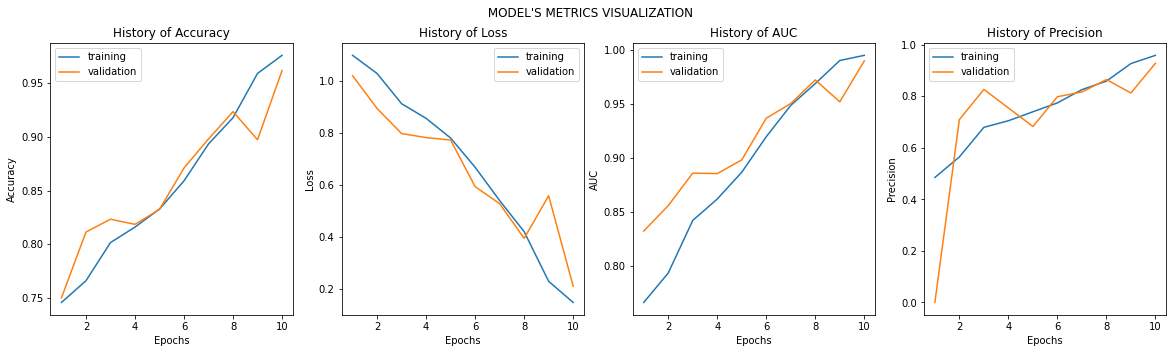

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 8s 193ms/step - loss: 0.2996 - accuracy: 0.9514 - precision: 0.9087 - recall: 0.8957 - auc: 0.9833
Train Accuracy: 99.03%
Validation Accuracy: 96.18%
Test Accuracy: 95.14%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.95
Precision =  0.91
Recall =  0.9
AUC =  0.98


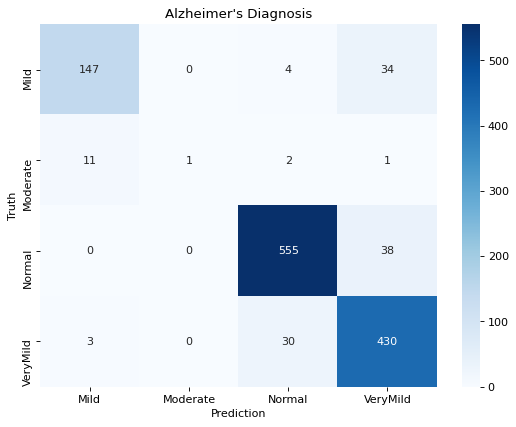

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       185
           1       1.00      0.07      0.12        15
           2       0.94      0.94      0.94       593
           3       0.85      0.93      0.89       463

    accuracy                           0.90      1256
   macro avg       0.93      0.68      0.70      1256
weighted avg       0.90      0.90      0.90      1256



# Saving the Model

In [ ]:
vg_model.save('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/vgg_leaky_relu.h5')

# Experiment 4 (Oversampling using SMOTE)
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change
* batch size = 20 while training
* Architecture = VGG16
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = ReLU
* SMOTE = Yes

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Apply SMOTE to oversample the data

In [ ]:
reshaped_train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]*train_data.shape[2]*3)
reshaped_train_data = np.array(reshaped_train_data)
print(reshaped_train_data.shape)

(4395, 109824)


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()

data_smote, train_labels_smote = sm.fit_resample(reshaped_train_data,train_labels)
print("Size of dataset after Oversampling using SMOTE",data_smote.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_data_smote = data_smote.reshape(data_smote[0], 176, 208, 3) # depend upon no of images that have oversampled, if error occurs in image size swap location of 176 and 208 as (208, 176, 3)

# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data_smote.shape)
print(train_labels_smote.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


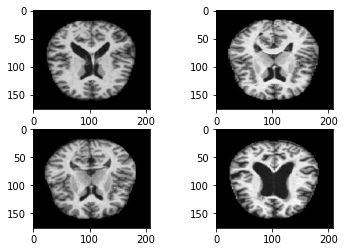

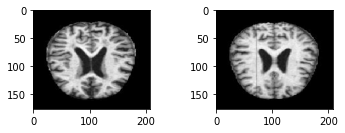

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data_smote[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data_smote[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data_smote))
print(np.amin(train_data_smote))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


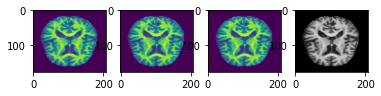

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data_smote[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data_smote[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data_smote[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data_smote[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation = 'relu',kernel_initializer='he_uniform') (flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data_smote,train_labels_smote,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data_smote, train_labels_smote)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
220/220 [==============================] - 156s 540ms/step - loss: 1.0987 - accuracy: 0.7457 - precision: 0.4847 - recall: 0.2746 - auc: 0.7665 - val_loss: 1.0203 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8326
Epoch 2/10
220/220 [==============================] - 110s 501ms/step - loss: 1.0288 - accuracy: 0.7659 - precision: 0.5645 - recall: 0.2787 - auc: 0.7938 - val_loss: 0.8940 - val_accuracy: 0.8113 - val_precision: 0.7092 - val_recall: 0.4156 - val_auc: 0.8561
Epoch 3/10
220/220 [==============================] - 110s 502ms/step - loss: 0.9126 - accuracy: 0.8015 - precision: 0.6792 - recall: 0.3902 - auc: 0.8424 - val_loss: 0.7976 - val_accuracy: 0.8232 - val_precision: 0.8262 - val_recall: 0.3710 - val_auc: 0.8861
Epoch 4/10
220/220 [==============================] - 110s 502ms/step - loss: 0.8562 - accuracy: 0.8159 - precision: 0.7048 - recall: 0.4537 - auc: 0.8622 - val_loss: 0.7822 - val_accuracy: 0.8185 - val_precision

# Plots and Values

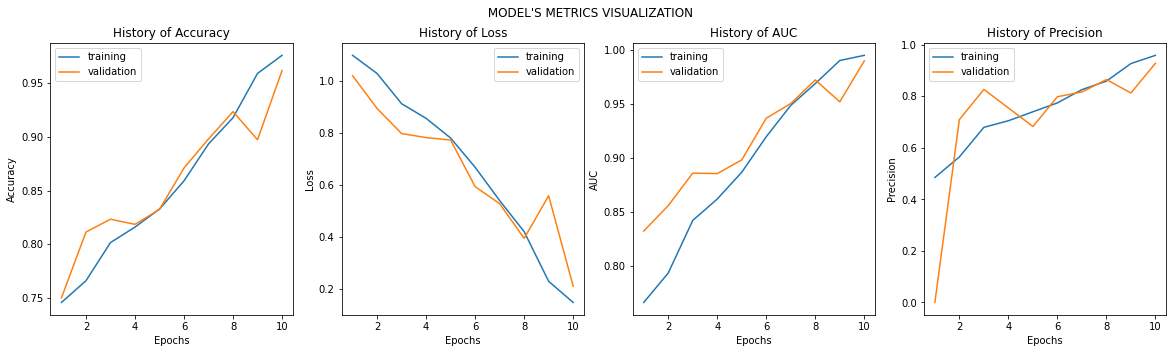

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data_smote, train_labels_smote)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 8s 193ms/step - loss: 0.2996 - accuracy: 0.9514 - precision: 0.9087 - recall: 0.8957 - auc: 0.9833
Train Accuracy: 99.03%
Validation Accuracy: 96.18%
Test Accuracy: 95.14%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.95
Precision =  0.91
Recall =  0.9
AUC =  0.98


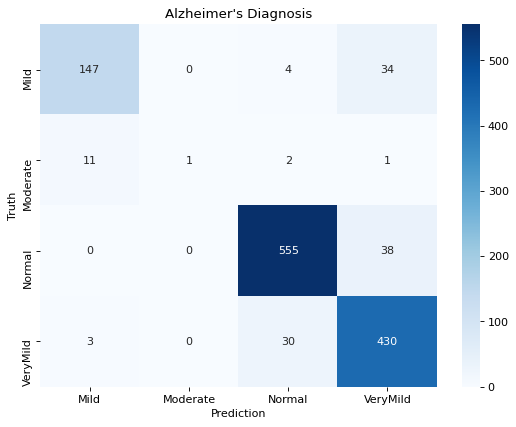

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       185
           1       1.00      0.07      0.12        15
           2       0.94      0.94      0.94       593
           3       0.85      0.93      0.89       463

    accuracy                           0.90      1256
   macro avg       0.93      0.68      0.70      1256
weighted avg       0.90      0.90      0.90      1256



# Saving the Model

In [ ]:
vg_model.save('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/vgg_smote.h5')

# Experiment 5 Changing Layers in VGG16 network and Adding more Data Augentation
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change, horizontal and vertical flip, width and height shift, 
* batch size = 20 while training
* Architecture = VGG16
* two hidden layer with 1024 amd 512 units as classification layer followed by dropout of 0.25 respectively
* activation function = ReLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           horizontal_flip = True,
                                                           vertical_flip = True,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


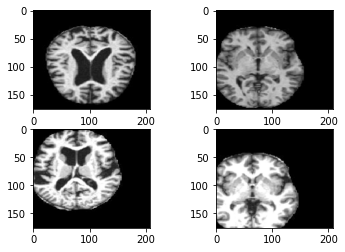

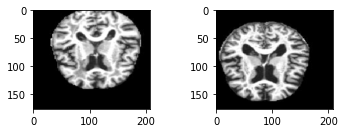

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


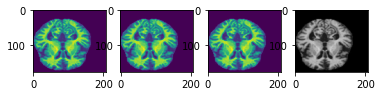

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation = 'relu',kernel_initializer='he_uniform') (flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)       
fc2 = Dense(512,activation = 'relu', kernel_initializer='he_uniform')(dp1)
dp2 = Dropout(0.25)(fc2)                                           
output = Dense(4,activation='softmax')(dp2)                                
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
220/220 [==============================] - 155s 537ms/step - loss: 1.1107 - accuracy: 0.7436 - precision: 0.4776 - recall: 0.2717 - auc: 0.7616 - val_loss: 1.0435 - val_accuracy: 0.7396 - val_precision: 0.4793 - val_recall: 0.4793 - val_auc: 0.7730
Epoch 2/10
220/220 [==============================] - 110s 498ms/step - loss: 1.0620 - accuracy: 0.7521 - precision: 0.5087 - recall: 0.2473 - auc: 0.7754 - val_loss: 1.0735 - val_accuracy: 0.7396 - val_precision: 0.4793 - val_recall: 0.4793 - val_auc: 0.7771
Epoch 3/10
220/220 [==============================] - 109s 498ms/step - loss: 1.0548 - accuracy: 0.7528 - precision: 0.5116 - recall: 0.2510 - auc: 0.7802 - val_loss: 1.0450 - val_accuracy: 0.7432 - val_precision: 0.4641 - val_recall: 0.1752 - val_auc: 0.7734
Epoch 4/10
220/220 [==============================] - 109s 497ms/step - loss: 1.0487 - accuracy: 0.7527 - precision: 0.5109 - recall: 0.2498 - auc: 0.7818 - val_loss: 1.0425 - val_accuracy: 0.7500 - val_precision: 0.0000

# Plots and Values

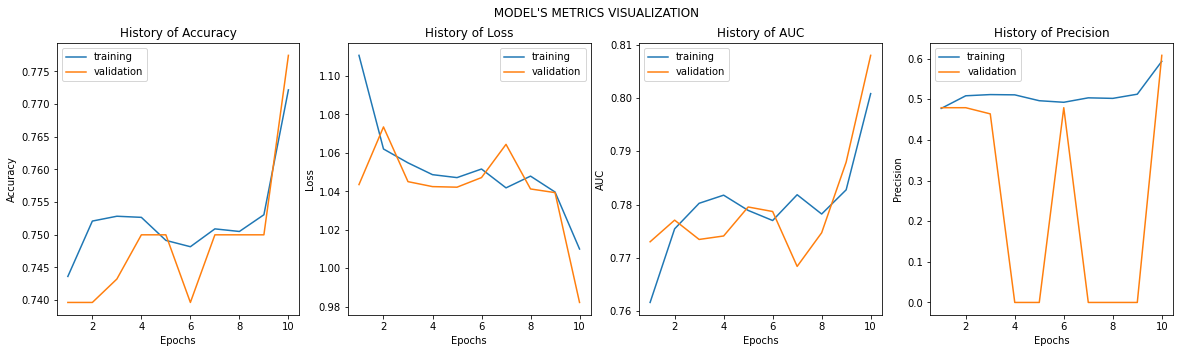

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 8s 189ms/step - loss: 0.9696 - accuracy: 0.7884 - precision: 0.6595 - recall: 0.3177 - auc: 0.8170
Train Accuracy: 78.91%
Validation Accuracy: 77.75%
Test Accuracy: 78.84%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.79
Precision =  0.66
Recall =  0.32
AUC =  0.82


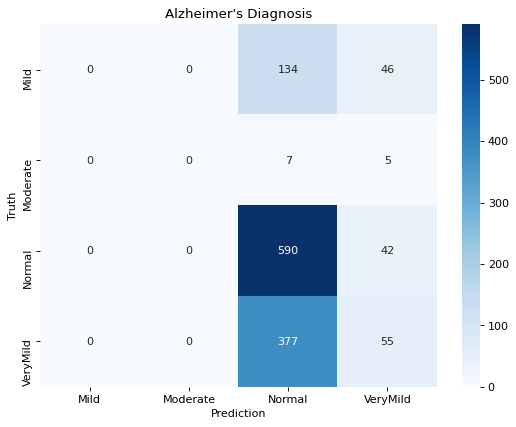

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.00      0.00      0.00        12
           2       0.53      0.93      0.68       632
           3       0.37      0.13      0.19       432

    accuracy                           0.51      1256
   macro avg       0.23      0.27      0.22      1256
weighted avg       0.40      0.51      0.41      1256



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Saving the Model

In [ ]:
vg_model.save('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/vgg_smote.h5')

# Experiment 6 Changing Layers in VGG16 network and Adding more Data Augmentation change Batch size
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change, horizontal and vertical flip, width and height shift, 
* batch size = 16 while training
* Architecture = VGG16
* two hidden layer with 1024 amd 512 units as classification layer followed by dropout of 0.25 respectively
* activation function = ReLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (224,224)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 32                   # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           horizontal_flip = True,
                                                           vertical_flip = True,
                                                           width_shift_range=0.2,
                                                           height_shift_range=0.2,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 224, 224, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 224, 224, 3)
validation (628, 224, 224, 3)
test (1256, 224, 224, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 224, 224, 3)
(4395, 4)
(628, 224, 224, 3)
(628, 4)
(1256, 224, 224, 3)
(1256, 4)


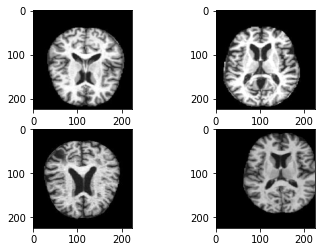

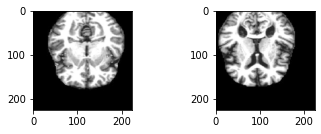

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


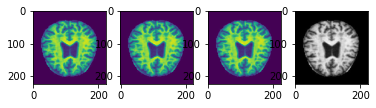

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation = 'relu',kernel_initializer='he_uniform') (flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.50)(fc1)       
fc2 = Dense(512,activation = 'relu', kernel_initializer='he_uniform')(dp1)
dp2 = Dropout(0.50)(fc2)                                           
output = Dense(4,activation='softmax')(dp2)                                
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=32, shuffle=True) 

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
138/138 [==============================] - 168s 897ms/step - loss: 1.2087 - accuracy: 0.7288 - precision: 0.4368 - recall: 0.2931 - auc: 0.7352 - val_loss: 1.0801 - val_accuracy: 0.7460 - val_precision: 0.4920 - val_recall: 0.4920 - val_auc: 0.7680
Epoch 2/10
138/138 [==============================] - 109s 789ms/step - loss: 1.1159 - accuracy: 0.7371 - precision: 0.4580 - recall: 0.2817 - auc: 0.7571 - val_loss: 1.0743 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7675
Epoch 3/10
138/138 [==============================] - 109s 789ms/step - loss: 1.0918 - accuracy: 0.7422 - precision: 0.4735 - recall: 0.2785 - auc: 0.7649 - val_loss: 1.0753 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7675
Epoch 4/10
138/138 [==============================] - 109s 788ms/step - loss: 1.0763 - accuracy: 0.7473 - precision: 0.4902 - recall: 0.2721 - auc: 0.7705 - val_loss: 1.0747 - val_accuracy: 0.7500 - val_p

# Plots and Values

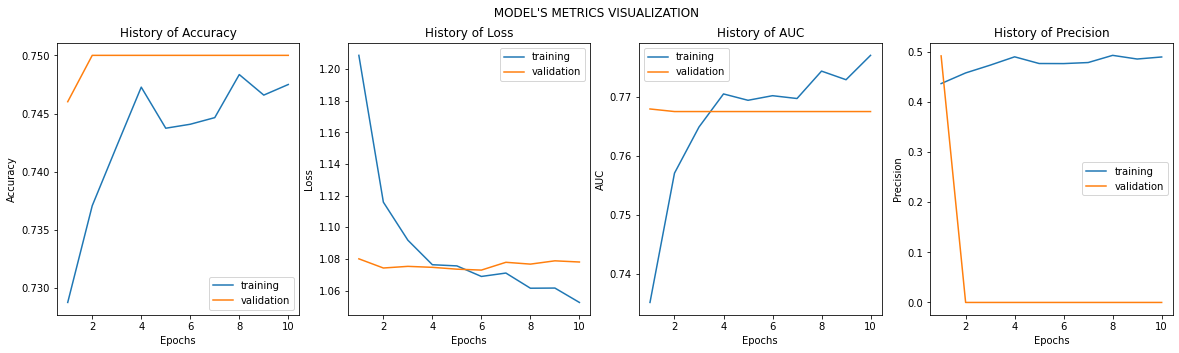

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 12s 306ms/step - loss: 1.0369 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7861
Train Accuracy: 75.00%
Validation Accuracy: 75.00%
Test Accuracy: 75.00%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.75
Precision =  0.0
Recall =  0.0
AUC =  0.79


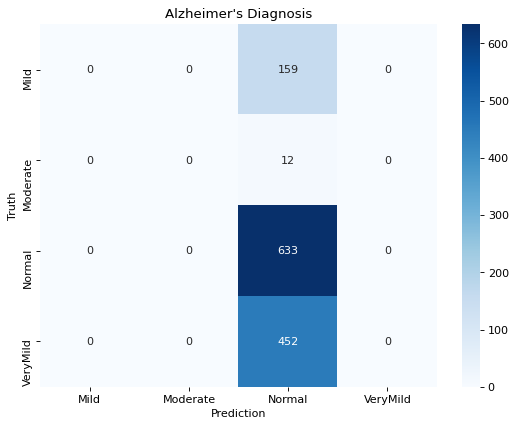

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       159
           1       0.00      0.00      0.00        12
           2       0.50      1.00      0.67       633
           3       0.00      0.00      0.00       452

    accuracy                           0.50      1256
   macro avg       0.13      0.25      0.17      1256
weighted avg       0.25      0.50      0.34      1256



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Saving the Model

In [ ]:
vg_model.save('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/vgg_smote.h5')

# Experiment 7
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change, horizontal and vertical flip
* batch size = 16 while training
* Architecture = VGG16
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = reLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 16                   # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           horizontal_flip = True,
                                                           vertical_flip = True,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              color_mode  = 'rgb',
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,
                                                          zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            color_mode  = 'rgb',
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split,random_state=3)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split,random_state=3)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


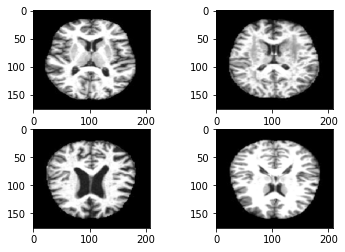

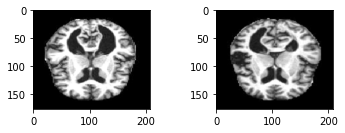

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


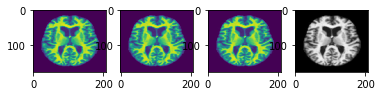

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=16, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
275/275 [==============================] - 110s 368ms/step - loss: 1.0972 - accuracy: 0.7444 - precision: 0.4799 - recall: 0.2685 - auc: 0.7652 - val_loss: 1.0357 - val_accuracy: 0.7504 - val_precision: 1.0000 - val_recall: 0.0016 - val_auc: 0.7927
Epoch 2/10
275/275 [==============================] - 94s 344ms/step - loss: 1.0161 - accuracy: 0.7684 - precision: 0.5701 - recall: 0.2999 - auc: 0.7973 - val_loss: 0.9015 - val_accuracy: 0.8014 - val_precision: 0.7745 - val_recall: 0.2898 - val_auc: 0.8425
Epoch 3/10
275/275 [==============================] - 94s 343ms/step - loss: 0.9874 - accuracy: 0.7794 - precision: 0.6226 - recall: 0.2981 - auc: 0.8062 - val_loss: 0.9009 - val_accuracy: 0.8018 - val_precision: 0.7289 - val_recall: 0.3296 - val_auc: 0.8383
Epoch 4/10
275/275 [==============================] - 94s 343ms/step - loss: 0.9231 - accuracy: 0.7950 - precision: 0.6934 - recall: 0.3226 - auc: 0.8313 - val_loss: 0.8780 - val_accuracy: 0.8037 - val_precision: 0.8293 - 

# Plots and Values

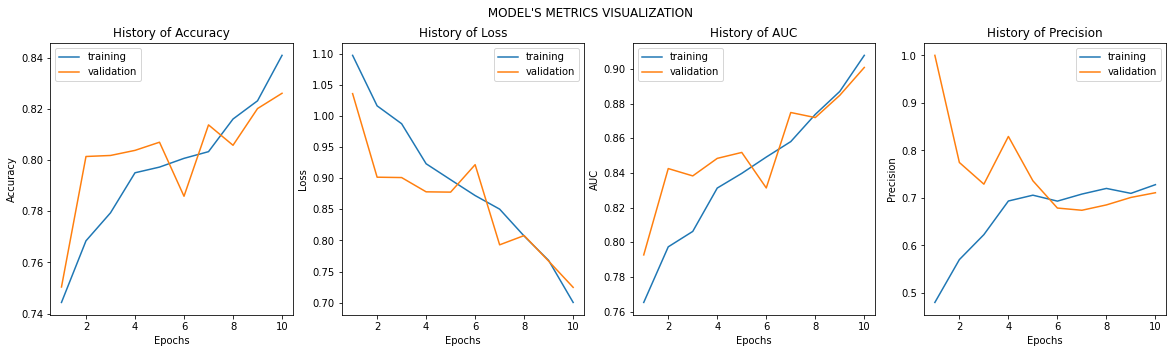

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 10s 241ms/step - loss: 0.7582 - accuracy: 0.8318 - precision: 0.7170 - recall: 0.5406 - auc: 0.8951
Train Accuracy: 88.35%
Validation Accuracy: 82.60%
Test Accuracy: 83.18%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.83
Precision =  0.72
Recall =  0.54
AUC =  0.9


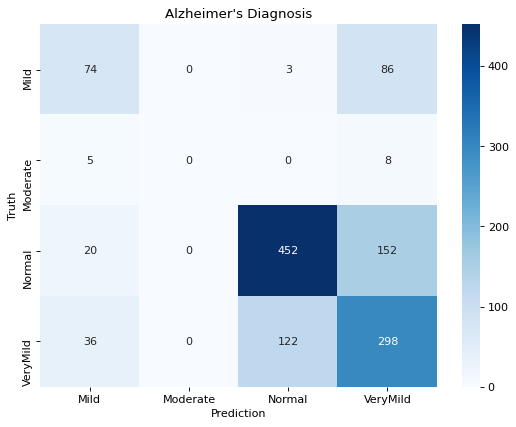

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.55      0.45      0.50       163
           1       0.00      0.00      0.00        13
           2       0.78      0.72      0.75       624
           3       0.55      0.65      0.60       456

    accuracy                           0.66      1256
   macro avg       0.47      0.46      0.46      1256
weighted avg       0.66      0.66      0.65      1256



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Experiment 8 Train AlexNet from Scratch
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change, horizontal flip
* batch size = 20 while training
* Architecture = AlexNet
* activation function = reLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 16                   # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           horizontal_flip = True,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              color_mode  = 'rgb',
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,
                                                          zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            color_mode  = 'rgb',
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split,random_state=3)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split,random_state=3)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


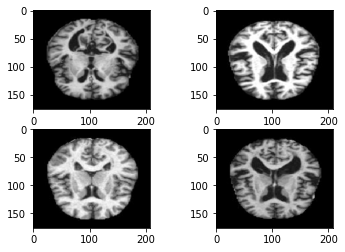

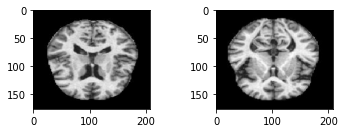

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


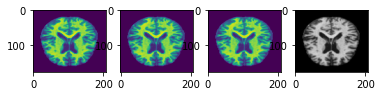

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
Create AlexNet Model from scratch

In [ ]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(dim[0],dim[1],3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(4))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 44, 52, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 44, 52, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 44, 52, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 26, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 26, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 26, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 22, 26, 256)      

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

AlexNet.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = AlexNet.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=20, shuffle=True) #changed batch size from 15

scores = AlexNet.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
220/220 [==============================] - 28s 104ms/step - loss: 1.2821 - accuracy: 0.7749 - precision: 0.6573 - recall: 0.2082 - auc: 0.6901 - val_loss: 1.1988 - val_accuracy: 0.7142 - val_precision: 0.4043 - val_recall: 0.3025 - val_auc: 0.7185
Epoch 2/10
220/220 [==============================] - 21s 95ms/step - loss: 1.1426 - accuracy: 0.7973 - precision: 0.7844 - recall: 0.2608 - auc: 0.7696 - val_loss: 1.6725 - val_accuracy: 0.6935 - val_precision: 0.3817 - val_recall: 0.3646 - val_auc: 0.7098
Epoch 3/10
220/220 [==============================] - 21s 97ms/step - loss: 1.0344 - accuracy: 0.8182 - precision: 0.8070 - recall: 0.3586 - auc: 0.8236 - val_loss: 1.3344 - val_accuracy: 0.7659 - val_precision: 0.5855 - val_recall: 0.2182 - val_auc: 0.6753
Epoch 4/10
220/220 [==============================] - 21s 97ms/step - loss: 0.8775 - accuracy: 0.8498 - precision: 0.8571 - recall: 0.4792 - auc: 0.8898 - val_loss: 1.5192 - val_accuracy: 0.7349 - val_precision: 0.4539 - val_

# Plots and Values

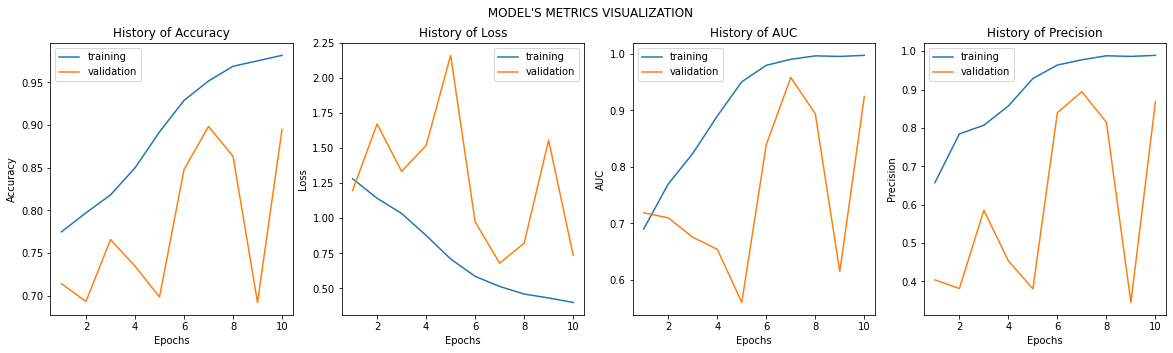

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = AlexNet.evaluate(train_data, train_labels)
val_scores = AlexNet.evaluate(val_data,val_labels)
test_scores = AlexNet.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 2s 39ms/step - loss: 0.6808 - accuracy: 0.9072 - precision: 0.8990 - recall: 0.7086 - auc: 0.9424
Train Accuracy: 96.73%
Validation Accuracy: 89.49%
Test Accuracy: 90.72%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.91
Precision =  0.9
Recall =  0.71
AUC =  0.94


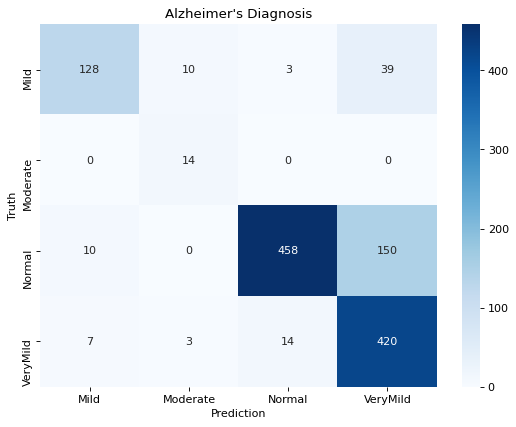

In [ ]:
## CONFUSION MATRIX ##

predic = AlexNet.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       180
           1       0.52      1.00      0.68        14
           2       0.96      0.74      0.84       618
           3       0.69      0.95      0.80       444

    accuracy                           0.81      1256
   macro avg       0.76      0.85      0.78      1256
weighted avg       0.85      0.81      0.81      1256



# Experiment 9 Train VGG19
* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change, horizontal flip
* batch size = 20 while training
* Architecture = VGG19
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = reLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 16                   # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           fill_mode='constant',
                                                           cval=0,
                                                           brightness_range=bright_range,
                                                           zoom_range=zoom,
                                                           horizontal_flip = True,
                                                           data_format='channels_last',
                                                           zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/train/",
                                              target_size=dim,
                                              color_mode  = 'rgb',
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',
                                                          cval=0,
                                                          zoom_range=[1,1],
                                                          data_format='channels_last') 

test_data_gen = test_dr.flow_from_directory(directory="/content/Alzheimer_s Dataset/test/",
                                            target_size=dim,
                                            color_mode  = 'rgb',
                                            batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
class_names = train_data_gen.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #Greyscale
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

# val_data,val_labels = val_data_gen.next()

In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split,random_state=3)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split,random_state=3)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


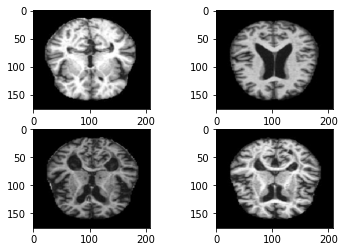

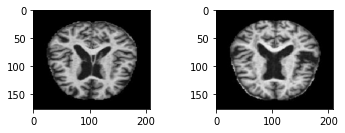

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


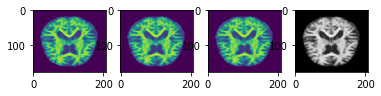

In [ ]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = VGG19(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_max_pooling2d


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv4').trainable = layers_unlocked
## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
275/275 [==============================] - 129s 436ms/step - loss: 1.0922 - accuracy: 0.7412 - precision: 0.4712 - recall: 0.2885 - auc: 0.7664 - val_loss: 1.0610 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.7767
Epoch 2/10
275/275 [==============================] - 113s 412ms/step - loss: 1.0572 - accuracy: 0.7486 - precision: 0.4945 - recall: 0.2578 - auc: 0.7766 - val_loss: 1.0448 - val_accuracy: 0.7560 - val_precision: 0.5131 - val_recall: 0.4666 - val_auc: 0.7891
Epoch 3/10
275/275 [==============================] - 113s 412ms/step - loss: 1.0472 - accuracy: 0.7491 - precision: 0.4964 - recall: 0.2521 - auc: 0.7796 - val_loss: 1.0574 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.8023
Epoch 4/10
275/275 [==============================] - 113s 412ms/step - loss: 1.0141 - accuracy: 0.7684 - precision: 0.5688 - recall: 0.3049 - auc: 0.7974 - val_loss: 0.9317 - val_accuracy: 0.8037 - val_precision: 0.7103

In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
275/275 [==============================] - 118s 428ms/step - loss: 0.7713 - accuracy: 0.8312 - precision: 0.7274 - recall: 0.5197 - auc: 0.8891 - val_loss: 0.9117 - val_accuracy: 0.8117 - val_precision: 0.6417 - val_recall: 0.5589 - val_auc: 0.8641
Epoch 2/10
275/275 [==============================] - 113s 411ms/step - loss: 0.7453 - accuracy: 0.8394 - precision: 0.7353 - recall: 0.5586 - auc: 0.8978 - val_loss: 0.8271 - val_accuracy: 0.8221 - val_precision: 0.6711 - val_recall: 0.5653 - val_auc: 0.8804
Epoch 3/10
275/275 [==============================] - 113s 410ms/step - loss: 0.6948 - accuracy: 0.8490 - precision: 0.7394 - recall: 0.6114 - auc: 0.9120 - val_loss: 0.8087 - val_accuracy: 0.8312 - val_precision: 0.7008 - val_recall: 0.5669 - val_auc: 0.8876
Epoch 4/10
275/275 [==============================] - 113s 410ms/step - loss: 0.6082 - accuracy: 0.8741 - precision: 0.7781 - recall: 0.6942 - auc: 0.9341 - val_loss: 0.7777 - val_accuracy: 0.8388 - val_precision: 0.6913

# Plots and Values

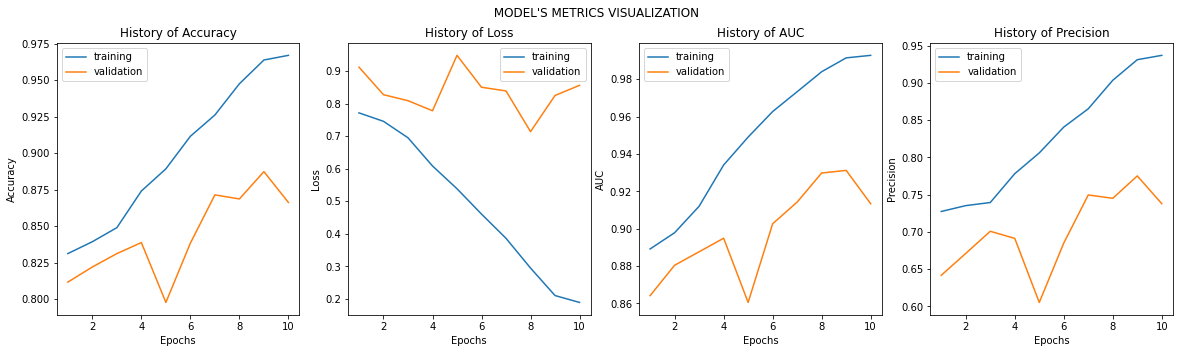

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

40/40 [==============================] - 9s 233ms/step - loss: 0.7814 - accuracy: 0.8664 - precision: 0.7396 - recall: 0.7189 - auc: 0.9216
Train Accuracy: 96.37%
Validation Accuracy: 86.62%
Test Accuracy: 86.64%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.87
Precision =  0.74
Recall =  0.72
AUC =  0.92


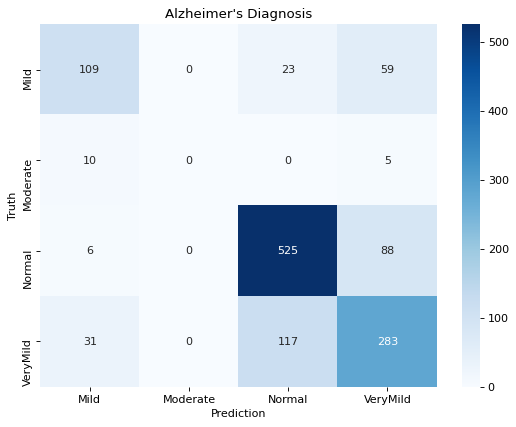

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
                yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print(classification_report(labels,predic))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63       191
           1       0.00      0.00      0.00        15
           2       0.79      0.85      0.82       619
           3       0.65      0.66      0.65       431

    accuracy                           0.73      1256
   macro avg       0.53      0.52      0.52      1256
weighted avg       0.72      0.73      0.72      1256



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train Best Model on MRI dataset of 5 stages of Alzheimer's disease from ADNI repository
[Dataset Download Link](https://www.kaggle.com/madhucharan/alzheimersdisease5classdatasetadni)

In [ ]:
!unzip '/content/drive/MyDrive/Alzheimer MRI Classification/ADNI.zip'

Archive:  /content/drive/MyDrive/Alzheimer MRI Classification/ADNI.zip
  inflating: Alzheimers-ADNI/test/Final AD JPEG/ADNI_002_S_4521_MR_Axial_T2-Star__br_raw_20160324122521837_22_S402609_I662501.jpg  
  inflating: Alzheimers-ADNI/test/Final AD JPEG/ADNI_006_S_4960_MR_Axial_T2-Star__br_raw_20151116142521022_22_S308848_I554365.jpg  
  inflating: Alzheimers-ADNI/test/Final AD JPEG/ADNI_012_S_4094_MR_Axial_T2_STAR__br_raw_20170911112516152_22_S606978_I902073.jpg  
  inflating: Alzheimers-ADNI/test/Final AD JPEG/ADNI_013_S_4395_MR_AXIAL_T2__STAR_br_raw_20160408152851491_22_S413787_I675059.jpg  
  inflating: Alzheimers-ADNI/test/Final AD JPEG/ADNI_024_S_4169_MR_AXIAL_T2_STAR__br_raw_20150824183510226_22_S269703_I506435.jpg  
  inflating: Alzheimers-ADNI/test/Final AD JPEG/ADNI_035_S_4114_MR_Axial_T2_STAR__br_raw_20180927135557122_22_S730896_I1053100.jpg  
  inflating: Alzheimers-ADNI/test/Final AD JPEG/ADNI_037_S_4214_MR_Axial_T2_TSE_with_Fat_Sat__br_raw_20151016131541571_22_S285609_I52705

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
import cv2
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# from sklearn.model_selection import KFold

start = time.time()


* Optimizer = Adam 
* learning rate = 0.0001
* Data Augmentation Techniques = image zooming, brightness change
* batch size = 20 while training
* Architecture = VGG16
* one hidden layer with 1024 units as classification layer followed by dropout of 0.25
* activation function = reLU
* SMOTE = None

# Set hyperparameters

In [ ]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 10                      # number of epochs to run                                             50
                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)


val20_epochs10


In [ ]:
labels = ['AD','CN','EMCI','LMCI','MCI']
def load_dataset(dataset_directory):
  size = (208,176) 
  dataset = []
  for label in labels: 
    path = os.path.join(dataset_directory, label)
    classes = labels.index(label)
    for data in os.listdir(path):
      try:
        image = cv2.imread(os.path.join(path, data))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,size,interpolation = cv2.INTER_CUBIC)
        dataset.append([image, classes])
      except Exception as e:
        print(e)
  return np.array(dataset)    

In [ ]:
train_data = load_dataset('/content/Alzheimers_ADNI/train/')
test_data = load_dataset('/content/Alzheimers_ADNI/test/')
print(train_data.shape)
print(test_data.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


(1101, 2)
(195, 2)


In [ ]:
def split(piv_feature_vector):
  input_piv_feature_vector = []
  output_labels = []

  for feature, label in piv_feature_vector:
    input_piv_feature_vector.append(feature)
    output_labels.append(label)
  return np.array(input_piv_feature_vector),np.array(output_labels)


In [ ]:
train_data, train_label = split(train_data)
test_data, test_label = split(test_data)


In [ ]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(1101, 176, 208, 3)
(195, 176, 208, 3)
(1101,)
(195,)


In [ ]:
# cocatenate arrays, combining all data

total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_label,test_label))
print(total_data.shape)
print(total_labels.shape)

(1296, 176, 208, 3)
(1296,)


In [ ]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (907, 176, 208, 3)
validation (130, 176, 208, 3)
test (259, 176, 208, 3)


In [ ]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels, 5)
test_labels = to_categorical(test_labels, 5)
val_labels = to_categorical(val_labels, 5)


# Sanity Checks

In [ ]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(907, 176, 208, 3)
(907, 5)
(130, 176, 208, 3)
(130, 5)
(259, 176, 208, 3)
(259, 5)


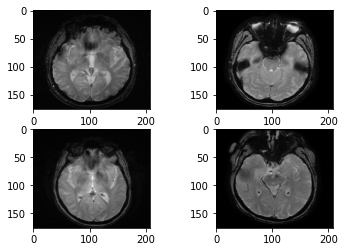

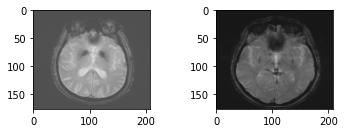

In [ ]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [ ]:
train_data = train_data.astype('float32') 
train_data /= 255
test_data = test_data.astype('float32') 
test_data /= 255
val_data = val_data.astype('float32') 
val_data /= 255

In [ ]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


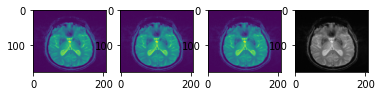

In [ ]:

# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        cval=0,
        brightness_range=bright_range,
        zoom_range=zoom,
        zca_whitening=False,
        fill_mode = 'constant')  

datagen.fit(train_data)

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [ ]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [ ]:
for i, layer in enumerate(vg_model.layers):
    print(i, layer.name)

0 input_4
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d_3


In [ ]:
## CHANGE MODEL STRUCTURE ##

# retrain some of the convolutional layers deep in the model, but not the fully connected layers at the end
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

## always leave last layer trainable ##
# vg_model.get_layer('block5_conv1').trainable = False
# vg_model.get_layer('block5_conv2').trainable = False
# vg_model.get_layer('block5_conv3').trainable = False

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.25)(fc1)                                                   # changed dropout here from .5
output = Dense(5,activation='softmax')(dp1)                                # changed to sigmoid from softmax
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0   

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.Adam(learning_rate=lr) 

vg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=METRICS)

# Train the Model



In [ ]:
# train the model
model_history = vg_model.fit(train_data,train_labels,validation_data=(val_data,val_labels), epochs=eps,batch_size=batch, shuffle=True) #changed batch size from 15

scores = vg_model.evaluate(train_data, train_labels)

print("Accuracy: %.2f%%" %(scores[1]*100))

Epoch 1/10
46/46 [==============================] - 54s 363ms/step - loss: 1.5331 - accuracy: 0.7954 - precision: 0.4651 - recall: 0.1544 - auc: 0.6729 - val_loss: 1.3397 - val_accuracy: 0.8031 - val_precision: 0.5077 - val_recall: 0.5077 - val_auc: 0.7479
Epoch 2/10
46/46 [==============================] - 11s 249ms/step - loss: 1.4463 - accuracy: 0.8011 - precision: 0.5083 - recall: 0.1687 - auc: 0.6985 - val_loss: 1.3319 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7394
Epoch 3/10
46/46 [==============================] - 12s 253ms/step - loss: 1.4256 - accuracy: 0.7996 - precision: 0.4953 - recall: 0.1169 - auc: 0.7085 - val_loss: 1.3294 - val_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7402
Epoch 4/10
46/46 [==============================] - 12s 255ms/step - loss: 1.4288 - accuracy: 0.7956 - precision: 0.4468 - recall: 0.0926 - auc: 0.7030 - val_loss: 1.3406 - val_accuracy: 0.8000 - val_precision: 0.

# Plots and Values

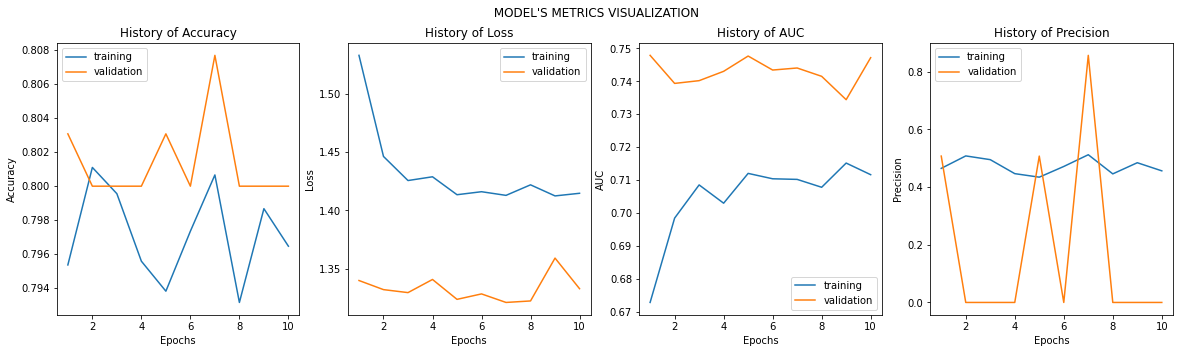

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision']
             
              )

# Performance Evaluation
Come here after loading model

In [ ]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

9/9 [==============================] - 2s 226ms/step - loss: 1.4941 - accuracy: 0.8000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6694
Train Accuracy: 80.00%
Validation Accuracy: 80.00%
Test Accuracy: 80.00%


In [ ]:
#test_scores = vg_model.evaluate(test_data, test_labels)
print("Accuracy = ", np.round(test_scores[1],2))
print("Precision = ", np.round(test_scores[2],2))
print("Recall = ", np.round(test_scores[3],2))
print("AUC = ", np.round(test_scores[4],2))

Accuracy =  0.8
Precision =  0.0
Recall =  0.0
AUC =  0.67


In [ ]:
print(train_label)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


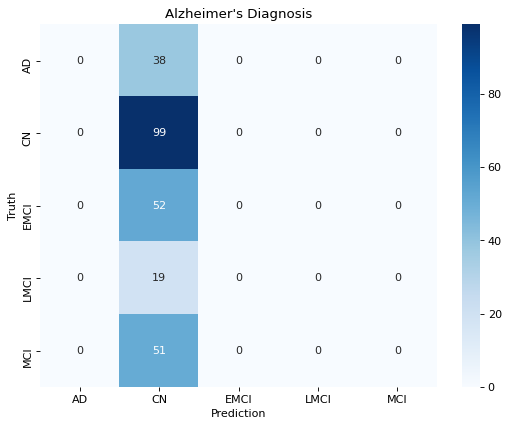

In [ ]:
## CONFUSION MATRIX ##

predic = vg_model.predict(test_data)

predic = np.argmax(predic, axis=1)
labels = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(labels, predic)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sn.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels= ['AD','CN','EMCI','LMCI','MCI'],
                yticklabels=['AD','CN','EMCI','LMCI','MCI'])
plt.title('Alzheimer\'s Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
# plt.subplots(figsize=(9, 6))
plt.show(ax)


In [ ]:
print("Test Cohen kappa Score",np.round(cohen_kappa_score(labels, predic),2))

Test Cohen kappa Score 0.0


In [ ]:
print(classification_report(labels,predic,target_names=['AD','CN','EMCI','LMCI','MCI']))

              precision    recall  f1-score   support

          AD       0.00      0.00      0.00        38
          CN       0.38      1.00      0.55        99
        EMCI       0.00      0.00      0.00        52
        LMCI       0.00      0.00      0.00        19
         MCI       0.00      0.00      0.00        51

    accuracy                           0.38       259
   macro avg       0.08      0.20      0.11       259
weighted avg       0.15      0.38      0.21       259



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Application Phase

In [ ]:
model = load_model('/content/drive/MyDrive/Alzheimer MRI Classification/saved model/my_model.h5')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 176, 208, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 208, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 208, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 104, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 104, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 104, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 52, 128)       0     

# GradCam

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## Prediction for Mild Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

0
Mild Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d_3
flatten_5
dense_10
dropout_5
dense_11


In [ ]:
icam = GradCAM(model, i,'block3_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


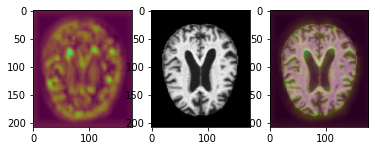

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Prediction for Moderate Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

1
Moderate Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d_3
flatten_5
dense_10
dropout_5
dense_11


In [ ]:
icam = GradCAM(model, i,'block4_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


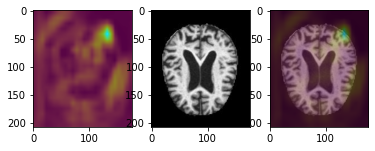

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Prediction for Non Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/NonDemented/26 (63).jpg')
image = cv2.resize(image, (208,176))
#image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

2
Non Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d_3
flatten_5
dense_10
dropout_5
dense_11


In [ ]:
icam = GradCAM(model, i,'block4_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/NonDemented/26 (63).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


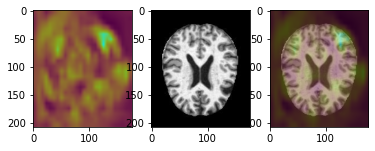

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

## Prediction for Very Mild Demented

In [ ]:
image = cv2.imread('/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (49).jpg')
image = cv2.resize(image, (208,176))
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image) 
i = np.argmax(preds[0])
print(i)
if i==0:
  print("Mild Demented")
elif i==1:
  print('Moderate Demented')
elif i==2:
  print("Non Demented")
elif i==3:
  print("Very Mild Demented")

3
Very Mild Demented


In [ ]:
for idx in range(len(model.layers)):
  print(model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer 

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d
flatten
dense
dropout
dense_1


In [ ]:
icam = GradCAM(model, i,'block4_conv3') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (176, 208))

image = cv2.imread('/content/Alzheimer_s Dataset/test/VeryMildDemented/26 (49).jpg')
image = cv2.resize(image, (176, 208))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(208, 176) (208, 176, 3)


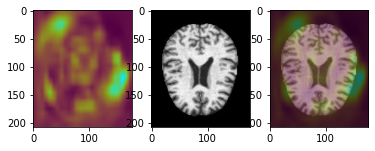

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)